## Step 1: Load and Preprocessing of Images

folder_path = './Datasets/Phase Shifter/No-Shift/Bitmap/'

In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the folder path
folder_path = './New Dataset/Phase-Shifter/'

# Initialize list to store images
images = []

# Target size for the images (make sure it's divisible by 4 to match pooling layers)
target_size = (128, 128)

# Loop through all the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(".bmp"):
        # Load the image
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        
        # Convert the image to grayscale
        image = image.convert('L')
        
        # Resize the image
        image = image.resize(target_size)
        
        # Convert the image to a numpy array
        image_array = np.array(image)
        
        # Append the processed image to the list
        images.append(image_array)

# Convert list to numpy array
images = np.array(images)

# Normalize the images
images = images / 255.0

# Add a channel dimension to the images (for CNN input)
images = np.expand_dims(images, axis=-1)

print("Total images loaded and preprocessed:", len(images))


Total images loaded and preprocessed: 61


## Step 2: Define and Train Autoencoder

Autoencoders can learn to compress and then reconstruct images, capturing essential features in the process.

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

# Define the autoencoder model
input_img = Input(shape=(images.shape[1], images.shape[2], 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(images, images, epochs=50, batch_size=4, shuffle=True, validation_split=0.2)

# Create the encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features from the images
features = encoder.predict(images)

print("Feature shape:", features.shape)


Epoch 1/50
12/12 [==============================] - 1s 45ms/step - loss: 0.5932 - val_loss: 0.3543
Epoch 2/50
12/12 [==============================] - 0s 37ms/step - loss: 0.1538 - val_loss: 0.1203
Epoch 3/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0685 - val_loss: 0.0647
Epoch 4/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0527 - val_loss: 0.0548
Epoch 5/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0475 - val_loss: 0.0486
Epoch 6/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0441 - val_loss: 0.0460
Epoch 7/50
12/12 [==============================] - 0s 39ms/step - loss: 0.0416 - val_loss: 0.0428
Epoch 8/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0444 - val_loss: 0.0546
Epoch 9/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0440 - val_loss: 0.0400
Epoch 10/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0386 - val_loss: 0.0386
Epoch 11/

## Step 3: Evaluate and Visualise Results

This autoencoder approach allows the model to learn and capture important features of the photonic design images without needing labeled data. From these learned features, further analysis and interpretation can be performed to understand and optimize photonic designs.

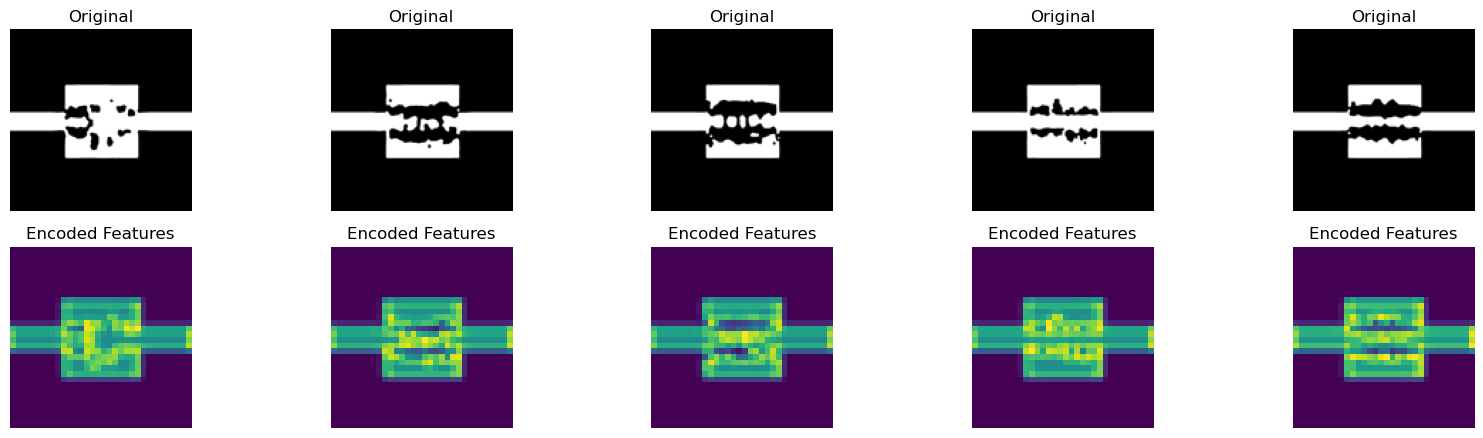

In [3]:
# Visualize the first 5 images and their features
n = 5  # Number of images to display
plt.figure(figsize=(20, 8))
for i in range(n):
    # Display original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(images[i].reshape(images.shape[1], images.shape[2]), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Display feature map
    ax = plt.subplot(3, n, i + 1 + n)
    feature_map = features[i].reshape(features.shape[1], features.shape[2], features.shape[3])
    plt.imshow(np.sum(feature_map, axis=-1), cmap='viridis')
    plt.title("Encoded Features")
    plt.axis('off')

plt.show()


# Interpretability

## 1. Visualising Feature Maps

To visualize the feature maps from the encoder to see which parts of the images are being focused on

2/2 [==============================] - 0s 10ms/step


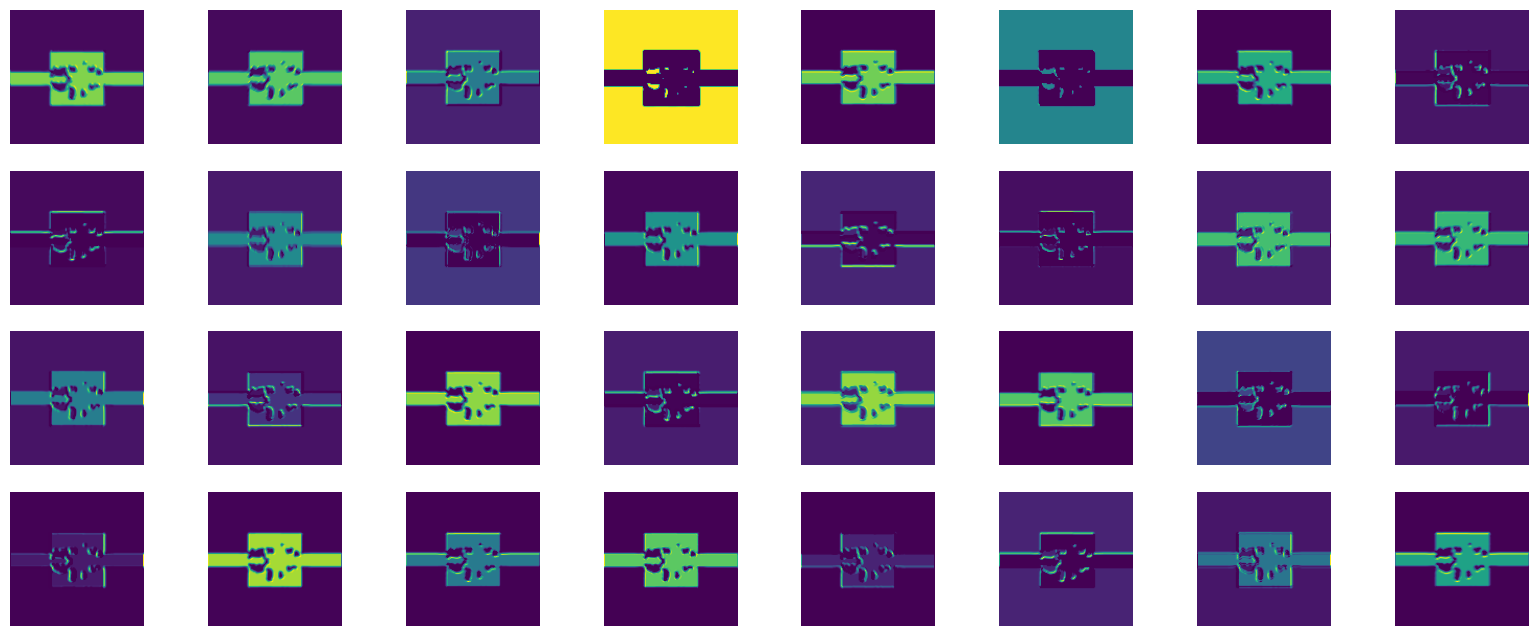

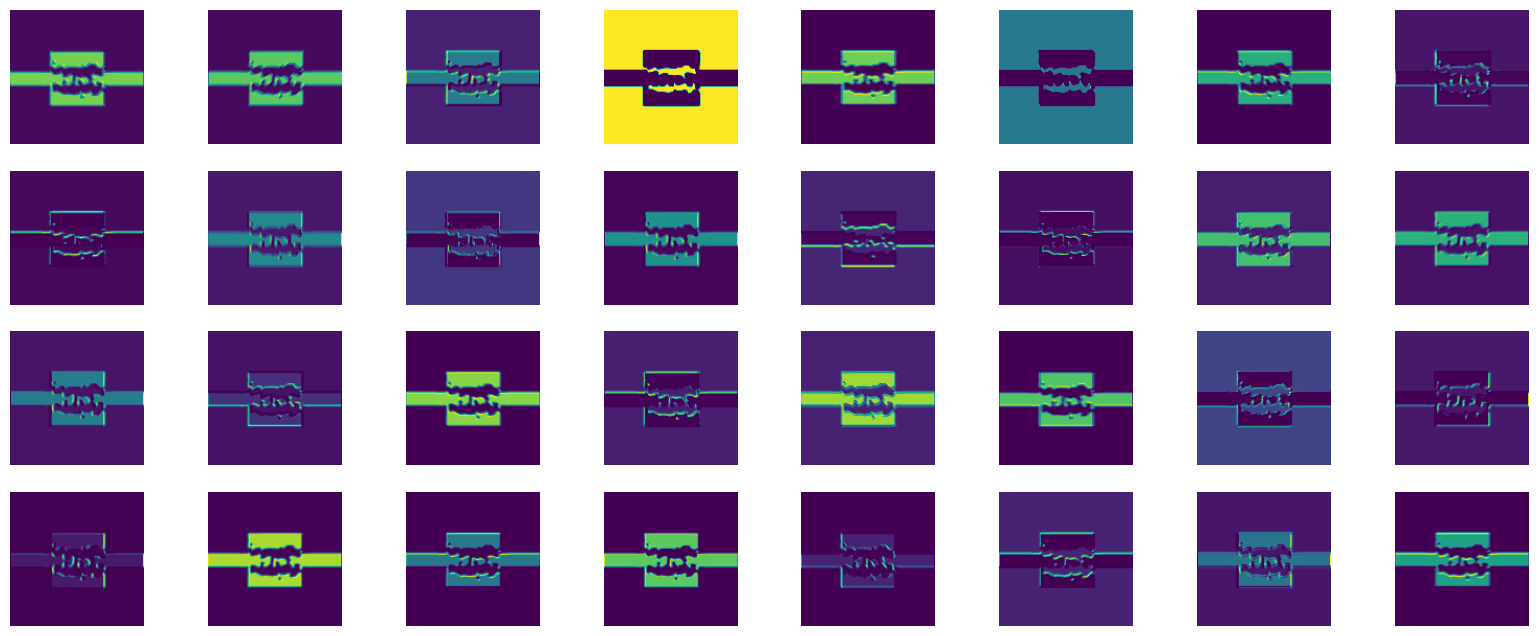

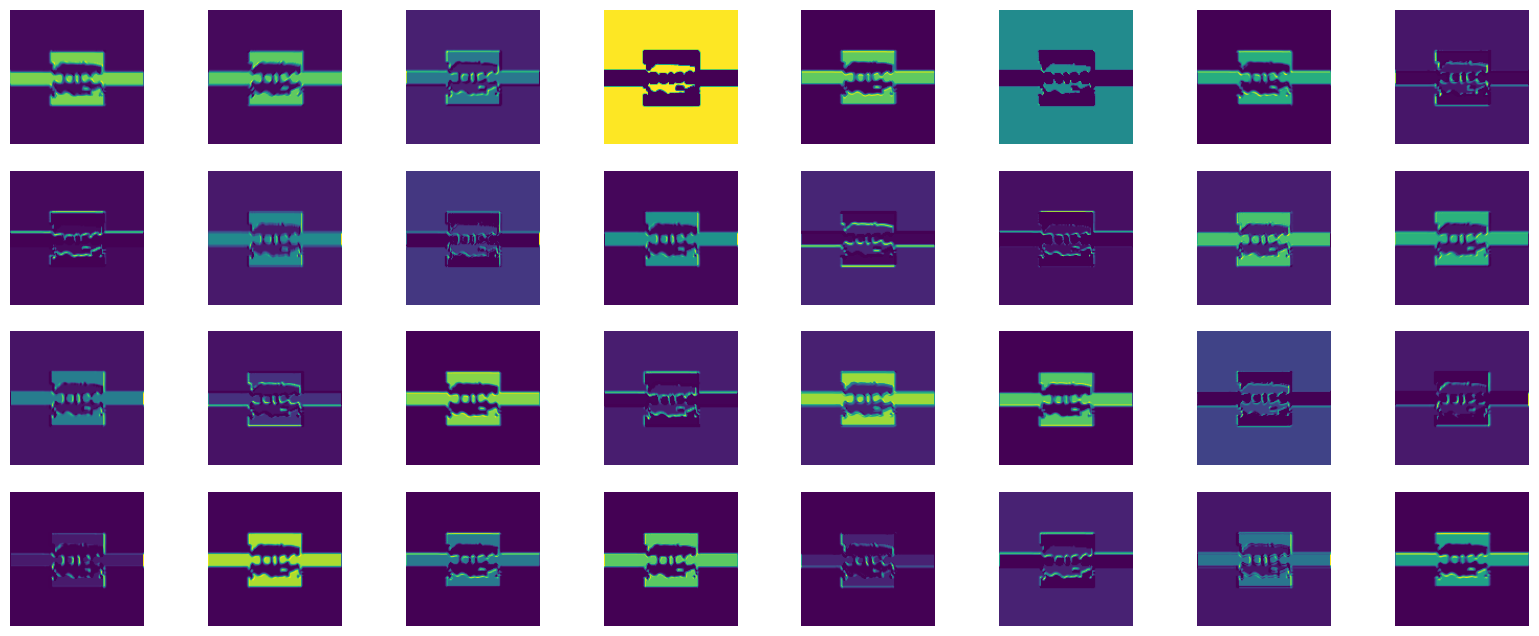

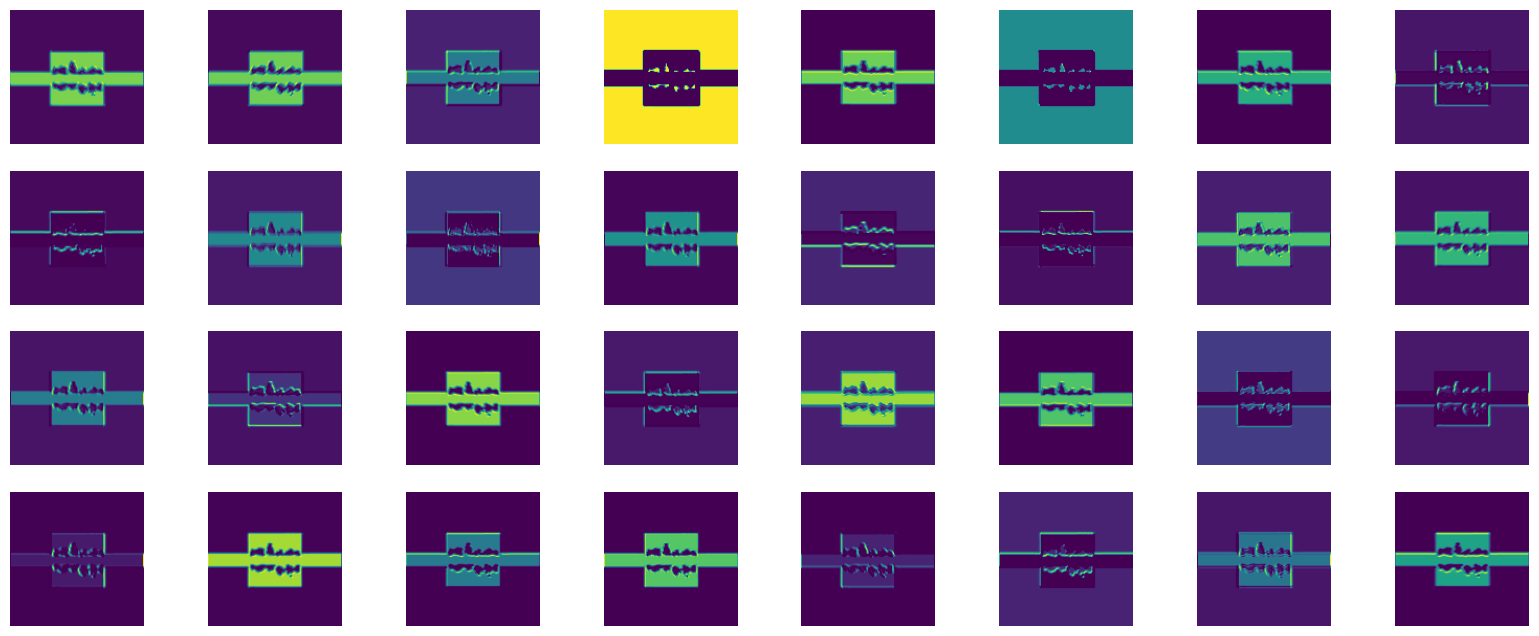

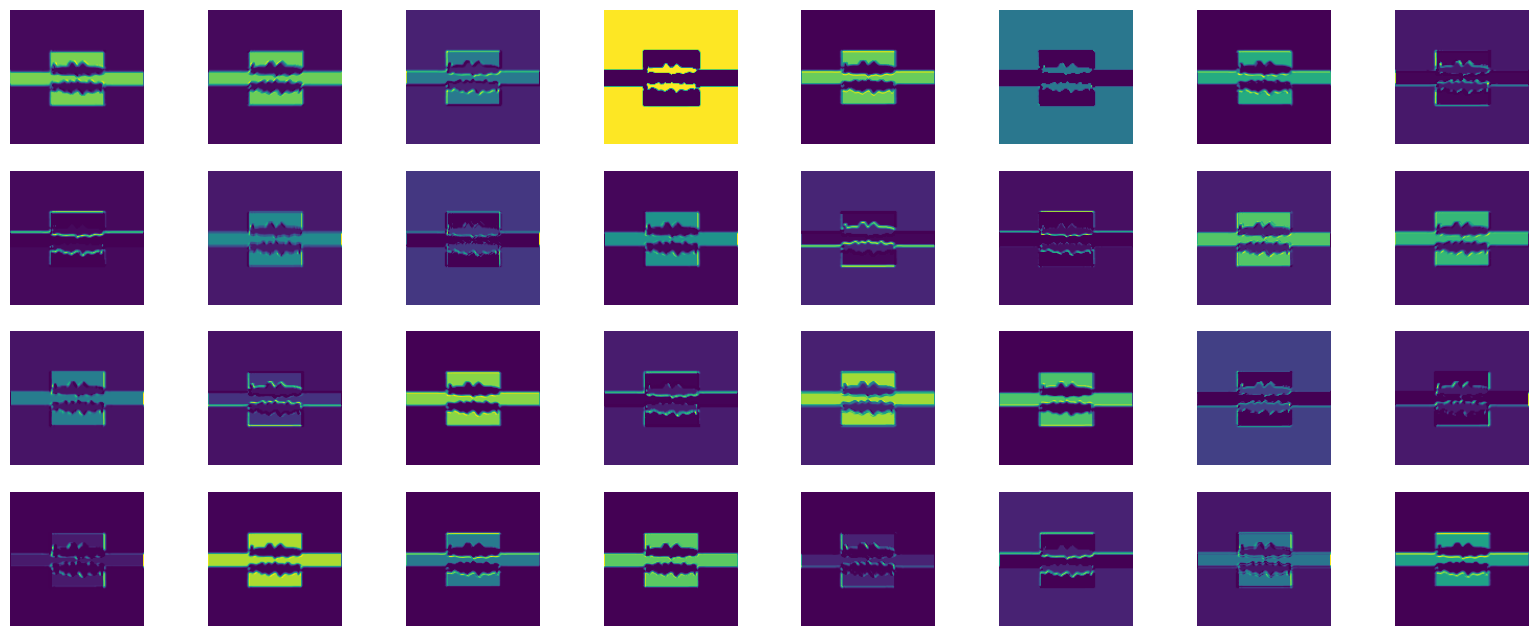

In [4]:
import matplotlib.pyplot as plt

# Function to plot feature maps
def plot_feature_maps(model, images, layer_idx):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[layer_idx].output)
    feature_maps = intermediate_model.predict(images)
    
    n = min(len(images), 5)  # Number of images to display
    for i in range(n):
        plt.figure(figsize=(20, 8))
        for j in range(feature_maps.shape[-1]):
            ax = plt.subplot(4, 8, j + 1)
            plt.imshow(feature_maps[i, :, :, j], cmap='viridis')
            plt.axis('off')
        plt.show()

# Plot feature maps from the first Conv2D layer
plot_feature_maps(encoder, images, 1)


## 2. Clustering Encoded Features

/Users/nayanthara/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


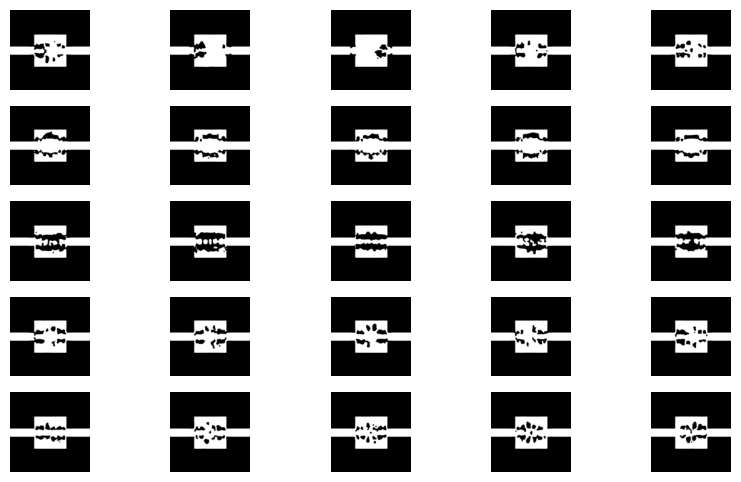

In [5]:
from sklearn.cluster import KMeans

# Flatten the encoded features for clustering
flattened_features = features.reshape(features.shape[0], -1)

# Apply K-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(flattened_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_images = images[clusters == i]
    for j in range(min(len(cluster_images), 5)):
        ax = plt.subplot(num_clusters, 5, i * 5 + j + 1)
        plt.imshow(cluster_images[j].reshape(128, 128), cmap='gray')
        plt.axis('off')
plt.show()


## 3. Grad-CAM for Visual Explanations

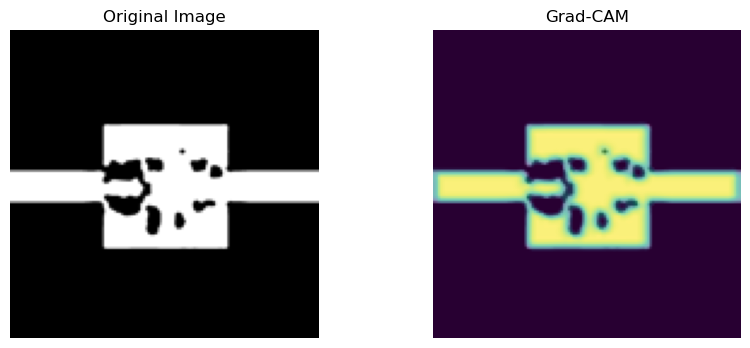

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to compute Grad-CAM
def compute_gradcam(model, image, layer_name):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = tf.reduce_mean(predictions)
    
    grads = tape.gradient(loss, conv_outputs)[0]
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = np.dot(conv_outputs[0], weights)
    
    # Resize the CAM to match the input image size
    cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
    
    # Apply ReLU to the CAM to remove negative values
    cam = np.maximum(cam, 0)
    
    # Normalize the CAM to the range [0, 1]
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap

# Ensure the image shape matches the model input shape
sample_image = images[0].reshape(128, 128, 1)

# Compute Grad-CAM for a sample image using conv2d_12 layer
heatmap = compute_gradcam(autoencoder, sample_image, 'conv2d_1')

# Display the original image and the heatmap
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.reshape(128, 128), cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(sample_image.reshape(128, 128), cmap='gray')
plt.imshow(heatmap, cmap='viridis', alpha=0.6)
plt.title('Grad-CAM')
plt.axis('off')
plt.show()


# LIME Method

**Using the LIME method:** Local Interpretable Model-Agnostic Explanations (LIME) is a powerful technique for interpreting machine learning models, including deep learning models like the one you are using for optics modeling. LIME works by approximating the model locally with an interpretable model (e.g., linear model or decision tree) and then providing insights into the model's behavior for individual predictions.

In [ ]:
#pip install lime

Epoch 1/50
12/12 [==============================] - 1s 50ms/step - loss: 0.5665 - val_loss: 0.2931
Epoch 2/50
12/12 [==============================] - 1s 45ms/step - loss: 0.1302 - val_loss: 0.0873
Epoch 3/50
12/12 [==============================] - 1s 46ms/step - loss: 0.0687 - val_loss: 0.0661
Epoch 4/50
12/12 [==============================] - 1s 47ms/step - loss: 0.0534 - val_loss: 0.0565
Epoch 5/50
12/12 [==============================] - 1s 46ms/step - loss: 0.0477 - val_loss: 0.0496
Epoch 6/50
12/12 [==============================] - 1s 45ms/step - loss: 0.0448 - val_loss: 0.0501
Epoch 7/50
12/12 [==============================] - 1s 47ms/step - loss: 0.0432 - val_loss: 0.0449
Epoch 8/50
12/12 [==============================] - 1s 47ms/step - loss: 0.0411 - val_loss: 0.0425
Epoch 9/50
12/12 [==============================] - 1s 47ms/step - loss: 0.0396 - val_loss: 0.0406
Epoch 10/50
12/12 [==============================] - 1s 49ms/step - loss: 0.0382 - val_loss: 0.0390
Epoch 11/

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


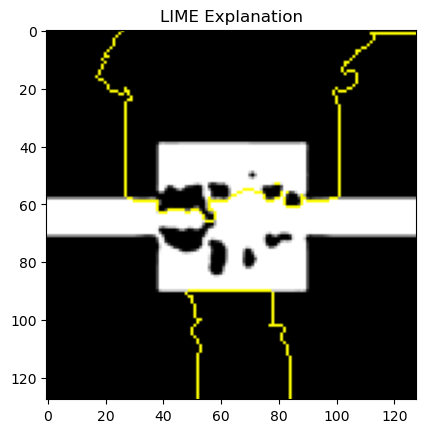

2/2 [==============================] - 0s 20ms/step


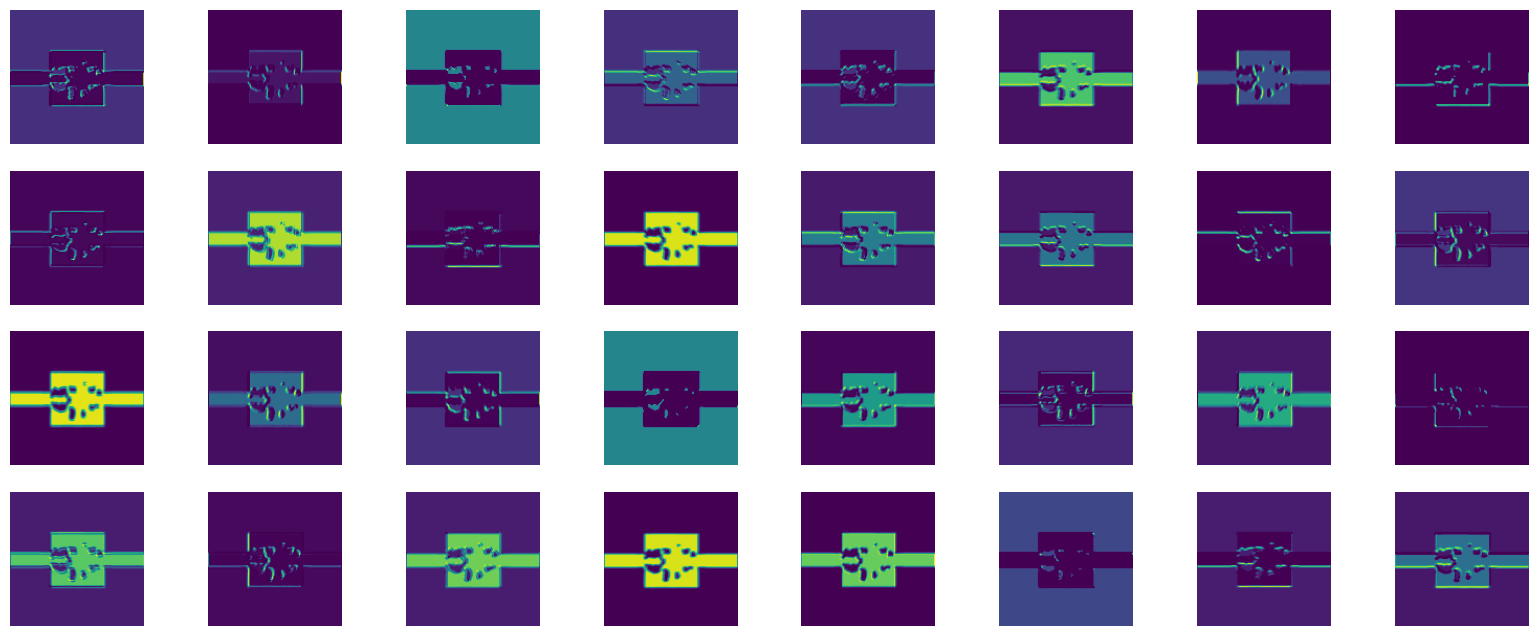

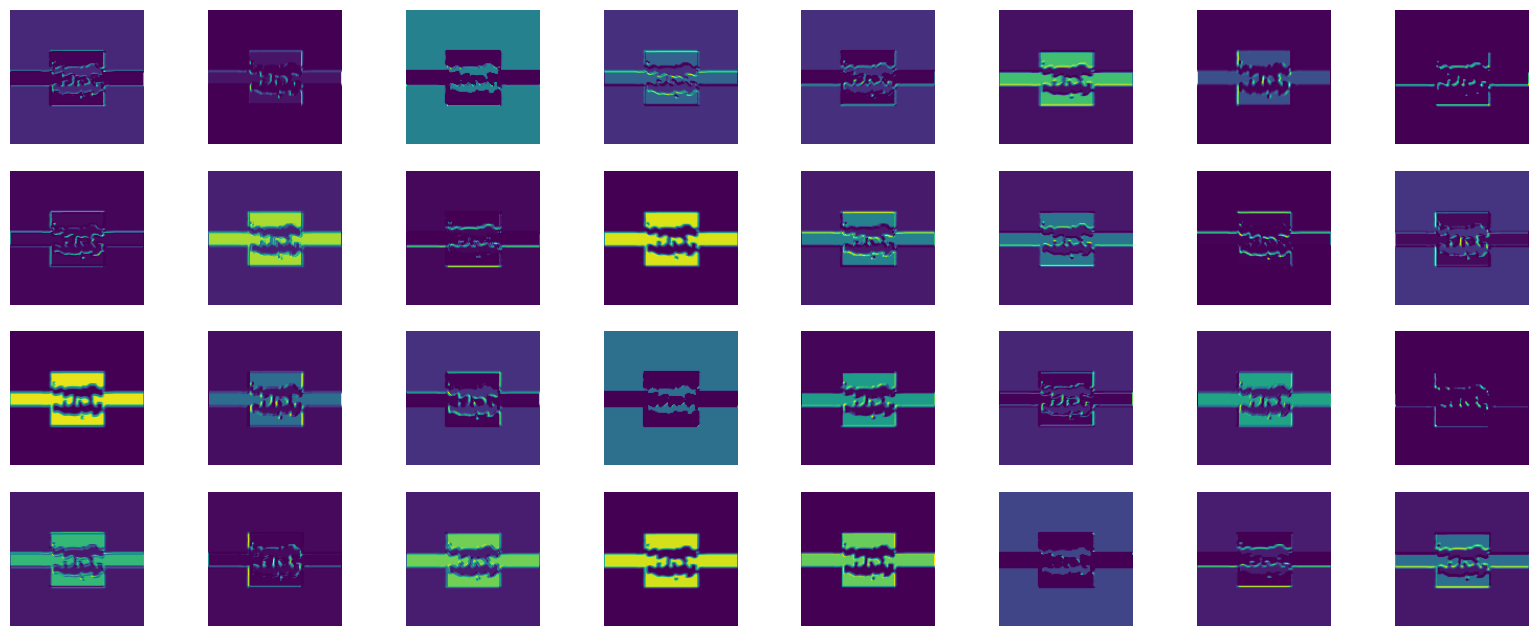

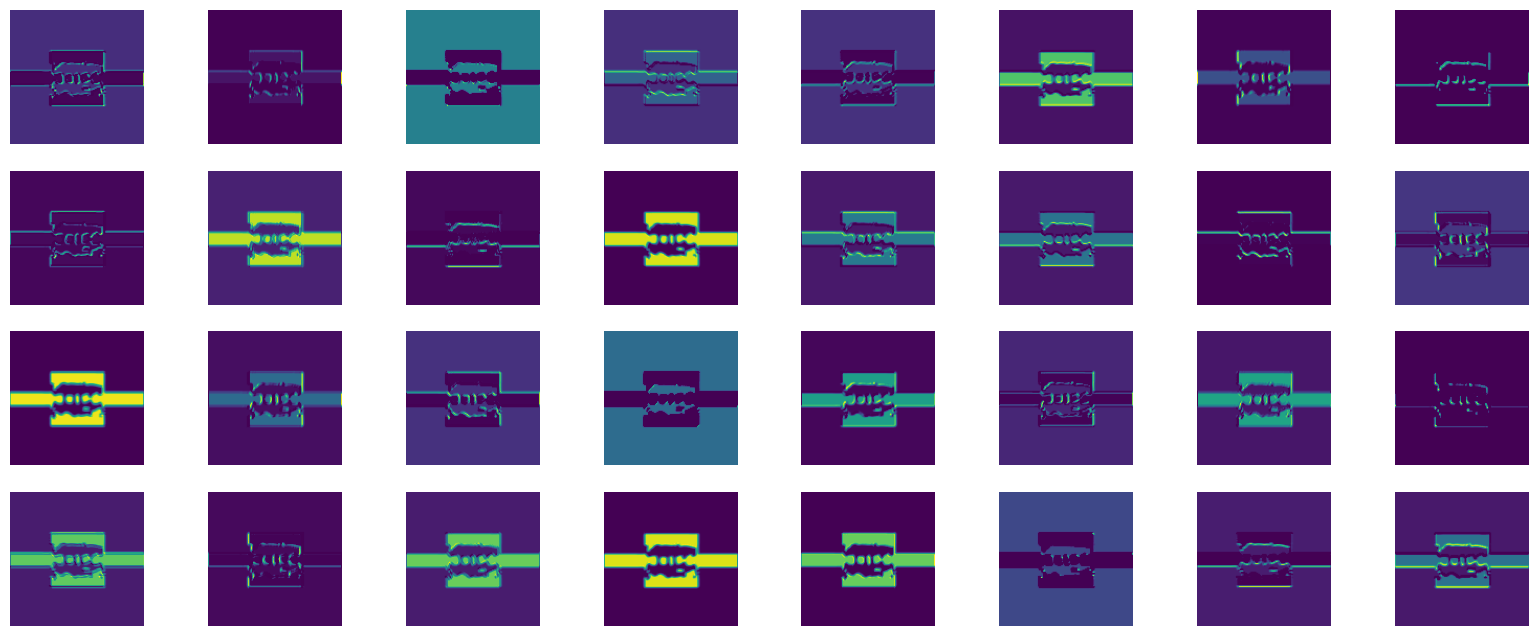

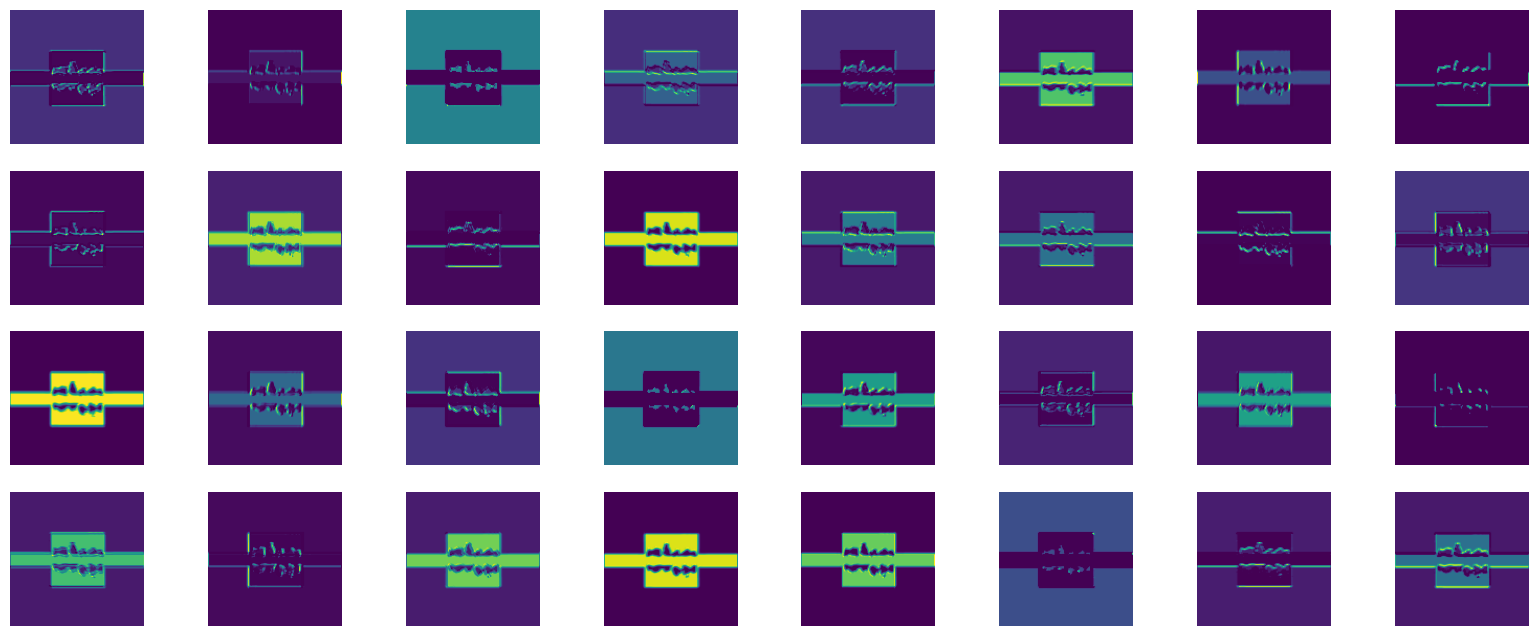

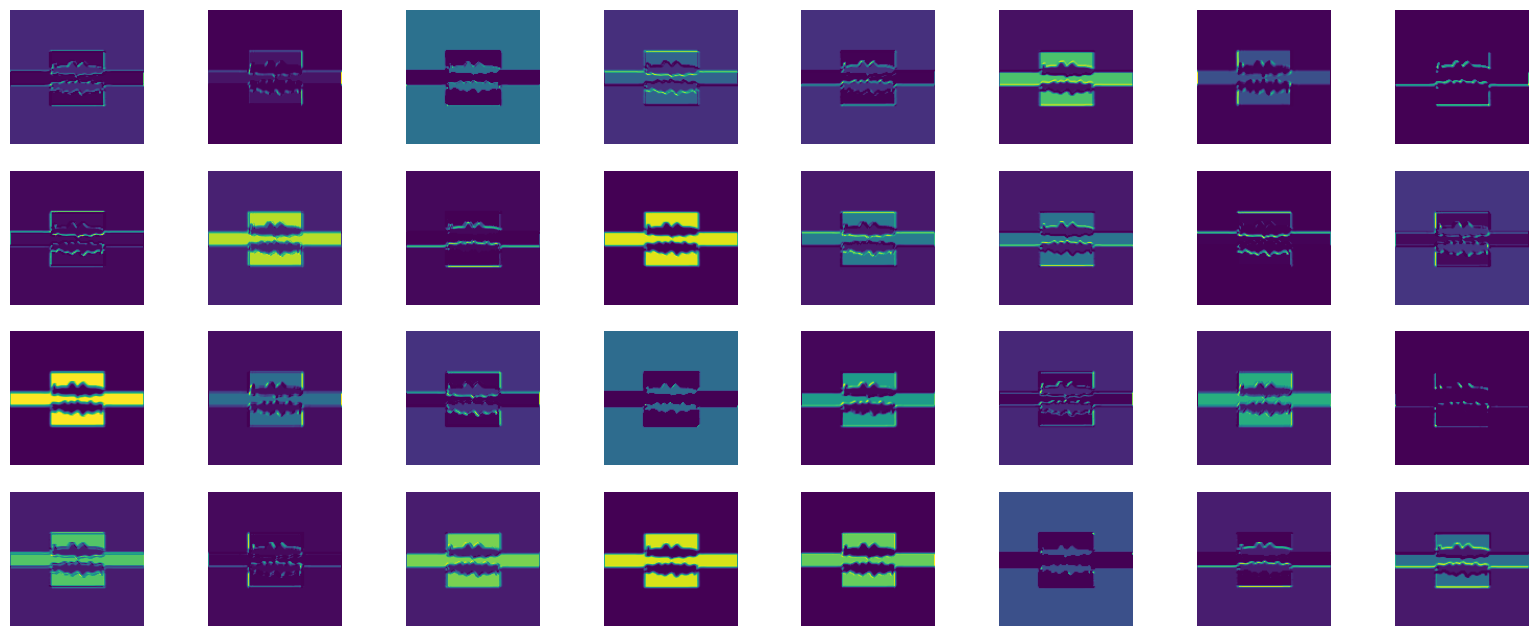

/Users/nayanthara/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


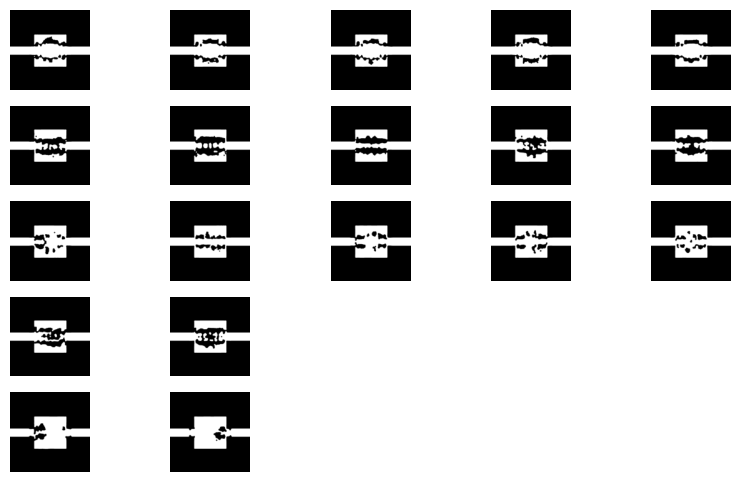

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.cluster import KMeans

# Define the autoencoder model
input_img = Input(shape=(images.shape[1], images.shape[2], 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(images, images, epochs=50, batch_size=4, shuffle=True, validation_split=0.2)

# Create the encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features from the images
features = encoder.predict(images)

print("Feature shape:", features.shape)

# Convert grayscale images to RGB for LIME
images_rgb = np.repeat(images, 3, axis=-1)

# Define the prediction function for LIME
def autoencoder_predict(images):
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert back to grayscale
    features = encoder.predict(images_gray)
    return features.reshape(features.shape[0], -1)

# Function to explain an instance using LIME
def explain_instance_with_lime(image, autoencoder_predict):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, autoencoder_predict, top_labels=1, hide_color=0, num_samples=1000)
    return explanation

# Function to plot LIME explanation
def plot_lime_explanation(explanation, image):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.axis('on')
    plt.show()

# Run the LIME explanation on a sample image
sample_image = images_rgb[0]  # Choose the first image for explanation

explanation = explain_instance_with_lime(sample_image, autoencoder_predict)
plot_lime_explanation(explanation, sample_image)

# Function to plot feature maps
def plot_feature_maps(model, images, layer_idx):
    intermediate_model = Model(inputs=model.input, outputs=model.layers[layer_idx].output)
    feature_maps = intermediate_model.predict(images)
    
    n = min(len(images), 5)  # Number of images to display
    for i in range(n):
        plt.figure(figsize=(20, 8))
        for j in range(feature_maps.shape[-1]):
            ax = plt.subplot(4, 8, j + 1)
            plt.imshow(feature_maps[i, :, :, j], cmap='viridis')
            plt.axis('off')
        plt.show()

# Plot feature maps from the first Conv2D layer
plot_feature_maps(encoder, images, 1)

# Flatten the encoded features for clustering
flattened_features = features.reshape(features.shape[0], -1)

# Apply K-means clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(flattened_features)

# Plot the clusters
plt.figure(figsize=(10, 6))
for i in range(num_clusters):
    cluster_images = images[clusters == i]
    for j in range(min(len(cluster_images), 5)):
        ax = plt.subplot(num_clusters, 5, i * 5 + j + 1)
        plt.imshow(cluster_images[j].reshape(128, 128), cmap='gray')
        plt.axis('off')
plt.show()

## Cropped Image - LIME Explanation

### Cropping the Images

In [9]:
import numpy as np

# Crop the image to the middle square region
def crop_to_middle_square(image, crop_size=64):
    center = image.shape[0] // 2
    half_crop = crop_size // 2
    return image[center-half_crop:center+half_crop, center-half_crop:center+half_crop, :]

# Crop all images in the dataset
cropped_images = np.array([crop_to_middle_square(img, 64) for img in images])


### Train autoencoder on cropped images

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

# Define the autoencoder model
input_img = Input(shape=(cropped_images.shape[1], cropped_images.shape[2], 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
history = autoencoder.fit(cropped_images, cropped_images, epochs=50, batch_size=4, shuffle=True, validation_split=0.2)

# Create the encoder model for feature extraction
encoder = Model(input_img, encoded)

# Extract features from the images
features = encoder.predict(cropped_images)

print("Feature shape:", features.shape)


Epoch 1/50
12/12 [==============================] - 0s 25ms/step - loss: 0.5215 - val_loss: 0.2829
Epoch 2/50
12/12 [==============================] - 0s 23ms/step - loss: 0.2270 - val_loss: 0.2036
Epoch 3/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1650 - val_loss: 0.1653
Epoch 4/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1439 - val_loss: 0.1478
Epoch 5/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1310 - val_loss: 0.1405
Epoch 6/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1301 - val_loss: 0.1216
Epoch 7/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1162 - val_loss: 0.1194
Epoch 8/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1085 - val_loss: 0.1101
Epoch 9/50
12/12 [==============================] - 0s 21ms/step - loss: 0.1031 - val_loss: 0.1052
Epoch 10/50
12/12 [==============================] - 0s 21ms/step - loss: 0.0996 - val_loss: 0.1034
Epoch 11/

### LIME Explanation on the Sample Cropped Image

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


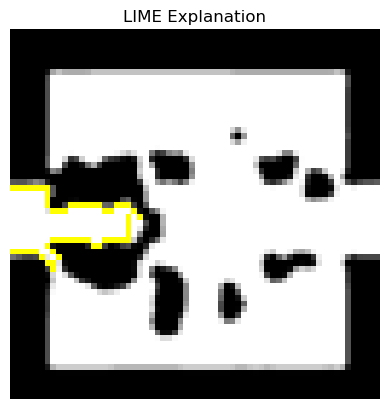

In [13]:
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Convert grayscale images to RGB for LIME
cropped_images_rgb = np.repeat(cropped_images, 3, axis=-1)

# Define the prediction function for LIME
def autoencoder_predict(images):
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert back to grayscale
    return encoder.predict(images_gray).reshape(images.shape[0], -1)

# Function to explain an instance using LIME
def explain_instance_with_lime(image, autoencoder_predict):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, autoencoder_predict, top_labels=1, hide_color=0, num_samples=1000)
    return explanation

# Function to plot LIME explanation
def plot_lime_explanation(explanation, image):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('LIME Explanation')
    plt.axis('off')
    plt.show()

# Run the LIME explanation on a sample cropped image
sample_image_rgb = cropped_images_rgb[0]  # Choose the first image for explanation


explanation = explain_instance_with_lime(sample_image_rgb, autoencoder_predict)
plot_lime_explanation(explanation, sample_image_rgb)


Running LIME on all images

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


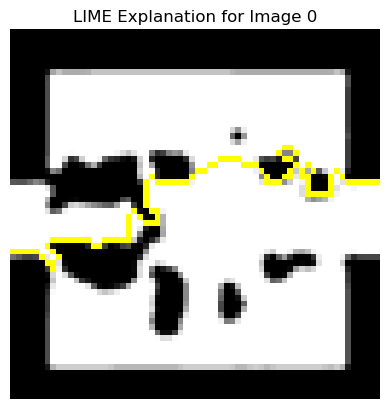

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


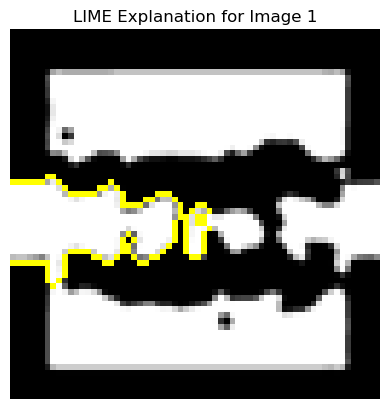

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


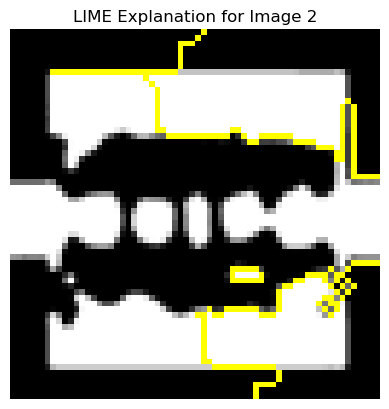

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


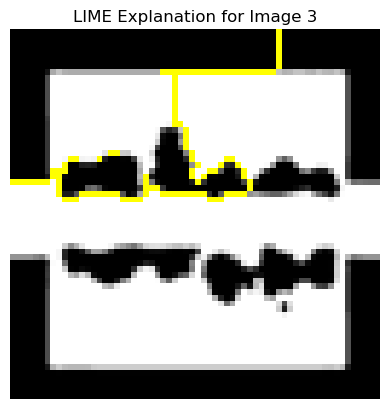

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


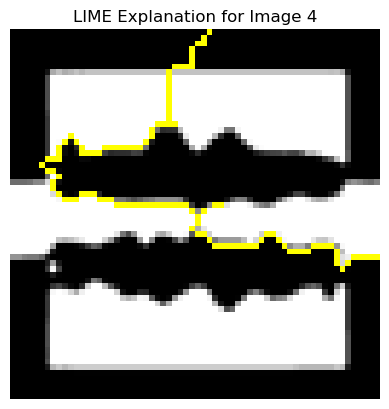

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


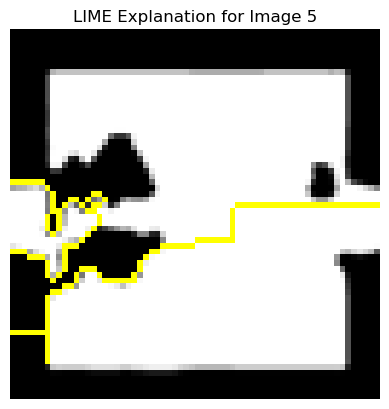

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


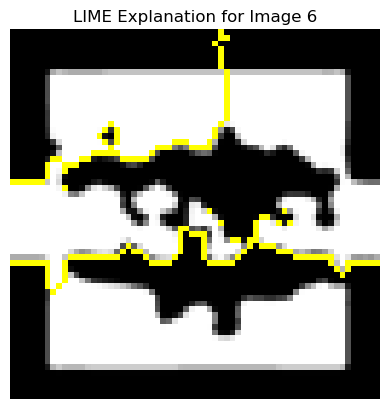

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


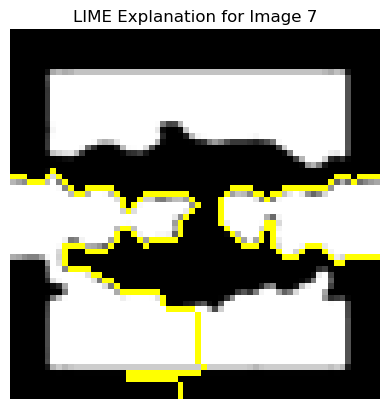

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


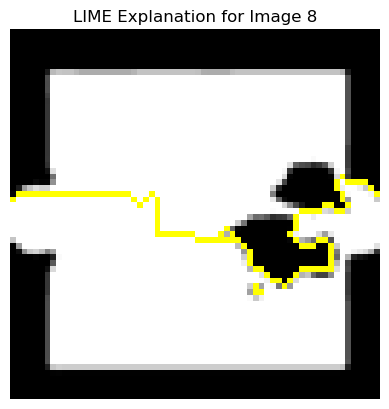

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 12ms/step


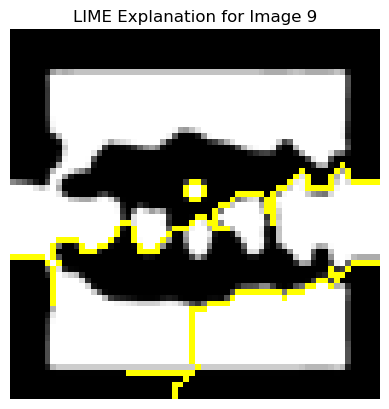

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


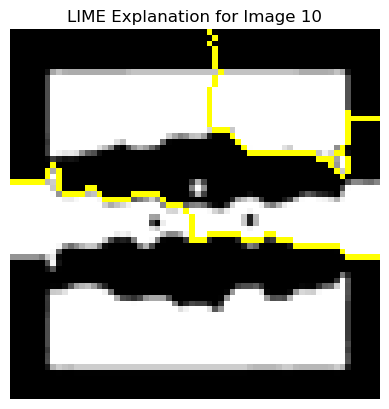

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


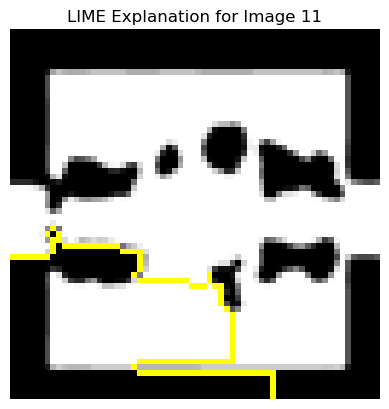

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


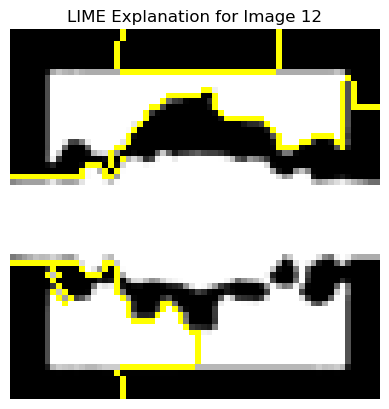

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


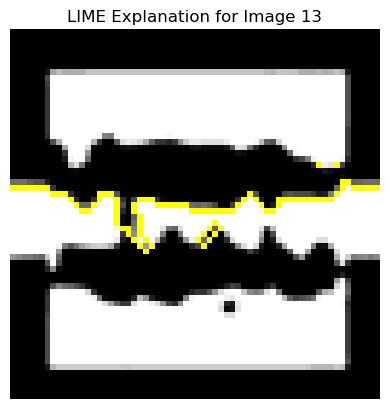

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


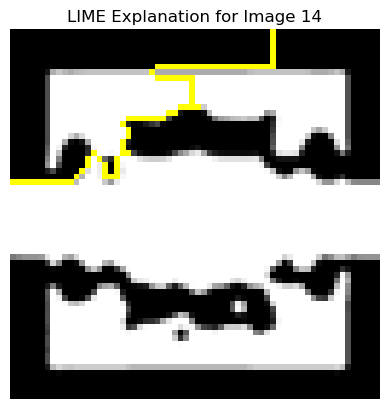

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


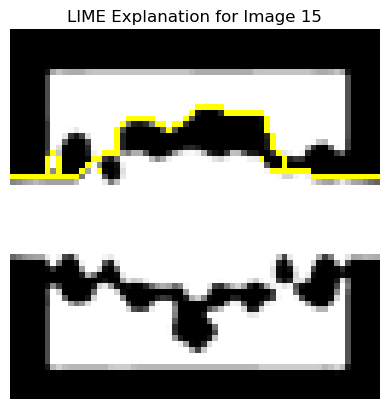

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


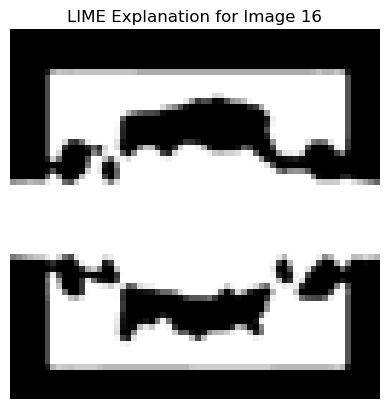

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


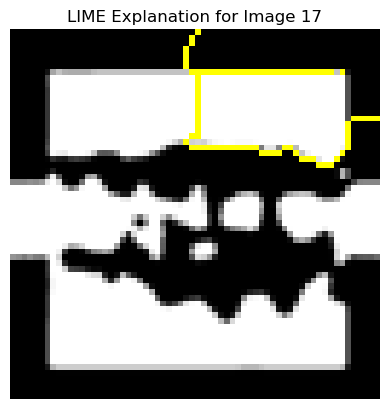

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


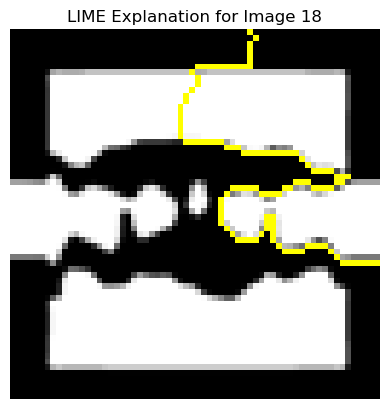

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


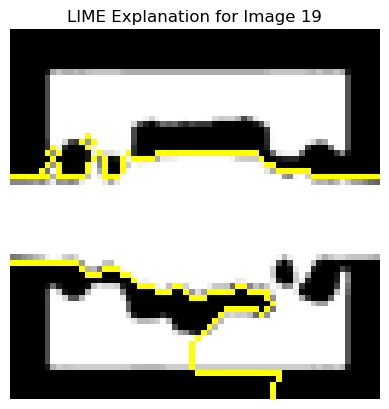

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


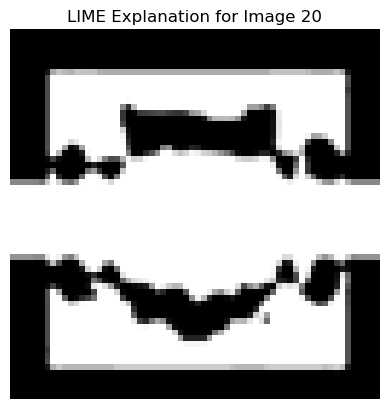

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


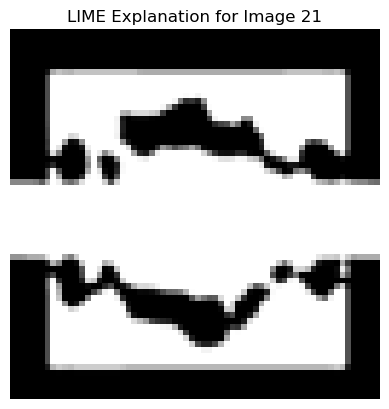

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


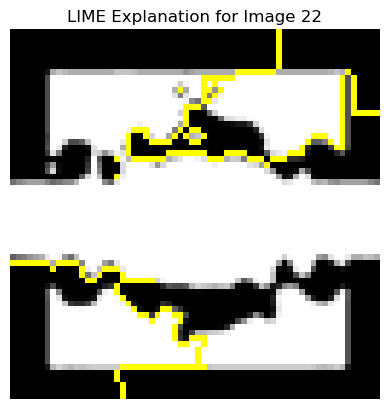

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


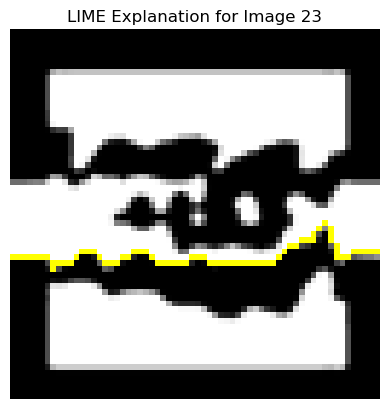

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


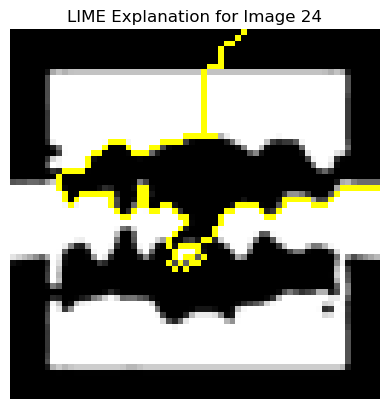

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


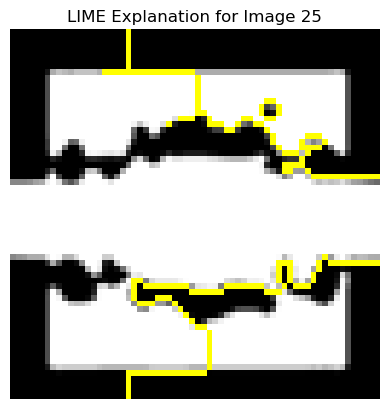

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


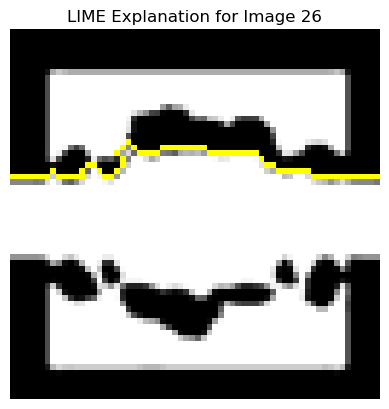

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


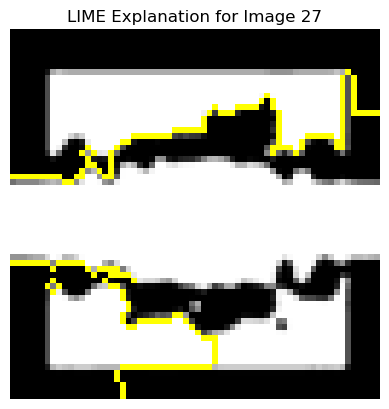

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


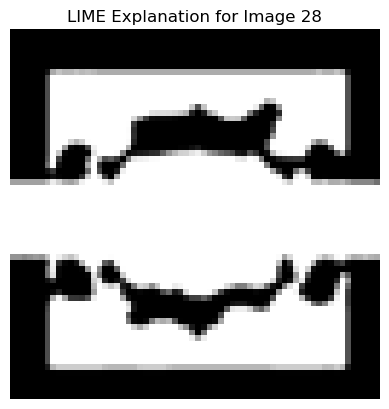

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


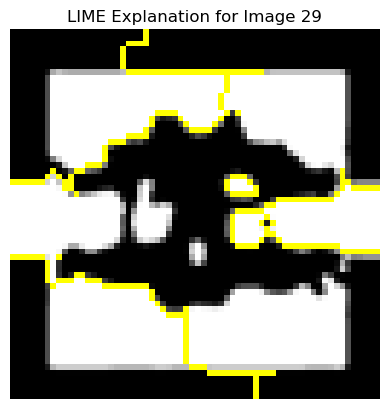

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


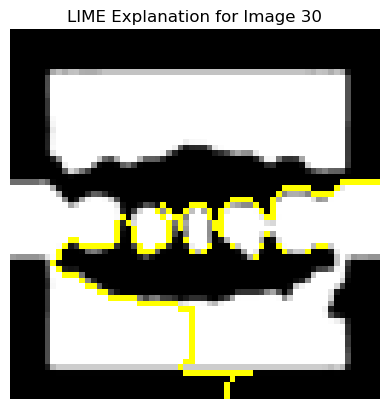

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


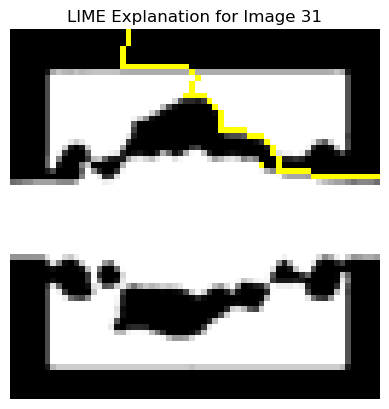

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


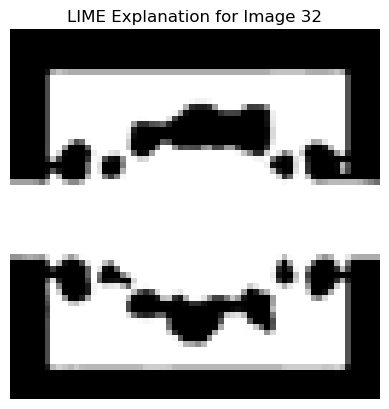

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


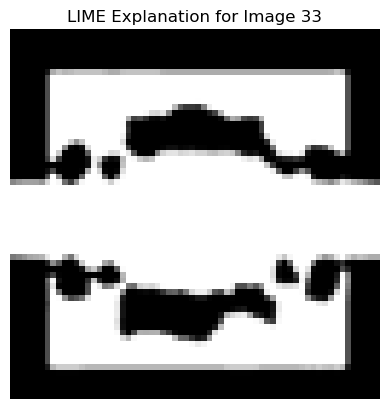

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


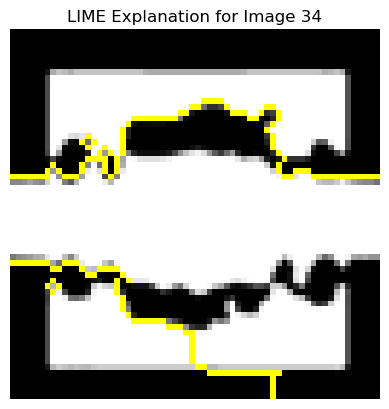

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


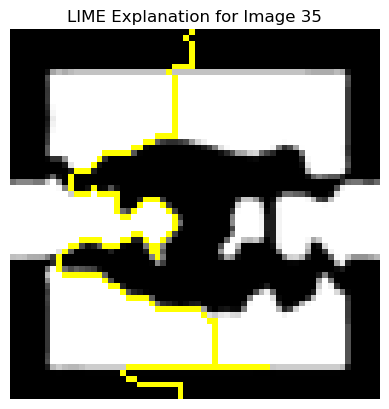

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


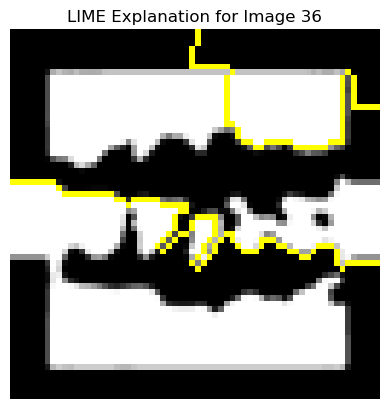

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


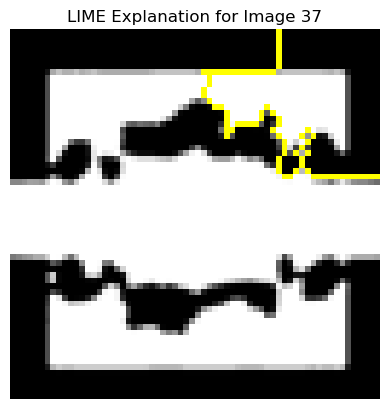

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


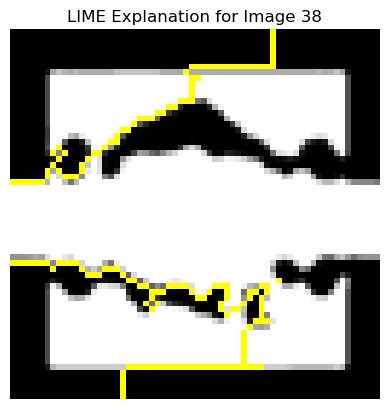

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


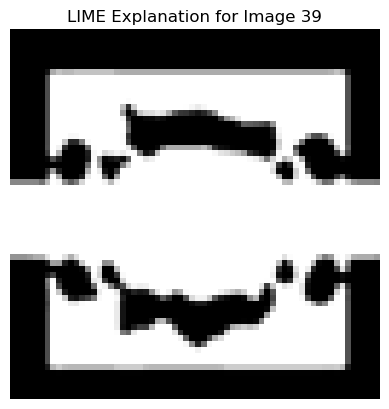

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


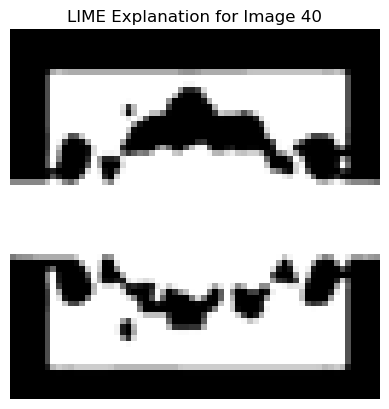

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


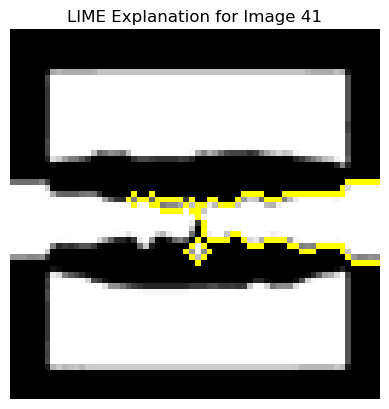

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


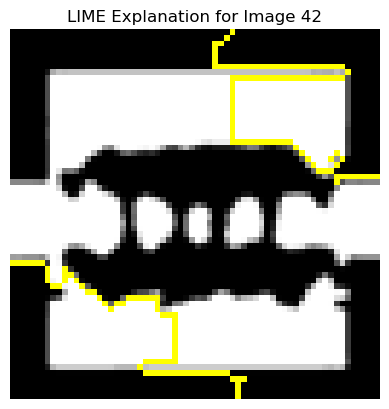

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


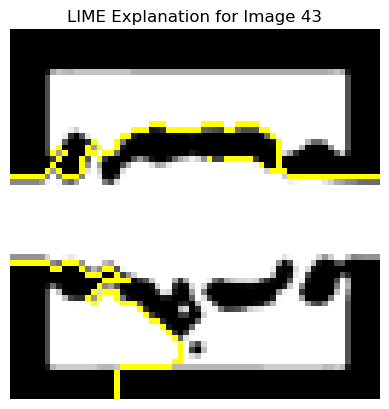

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


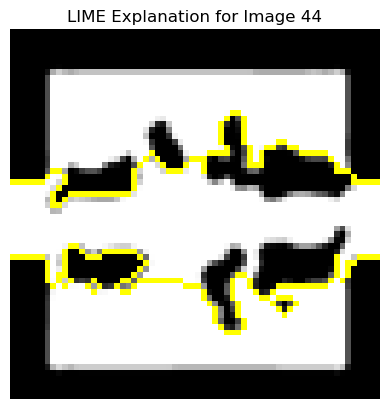

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


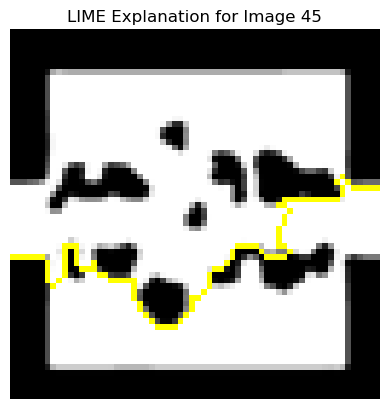

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


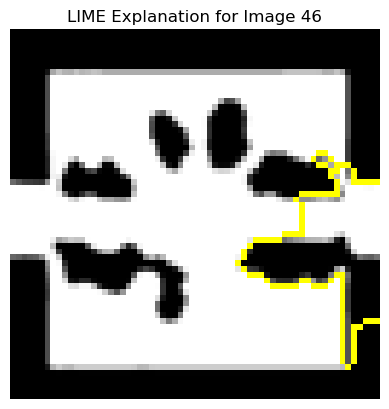

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


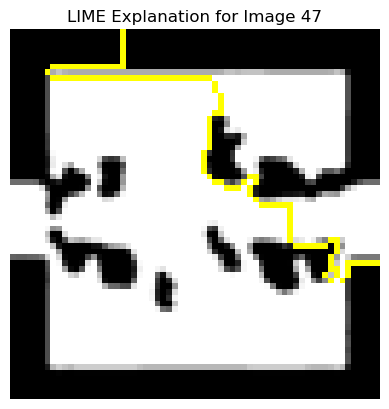

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


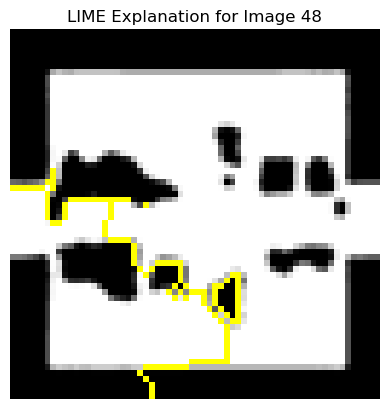

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


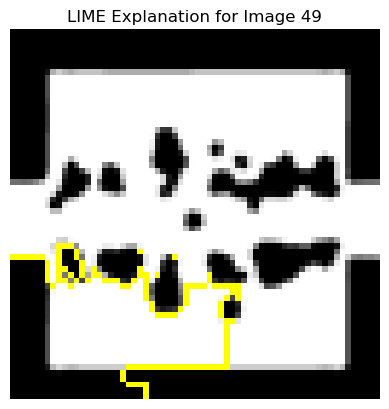

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


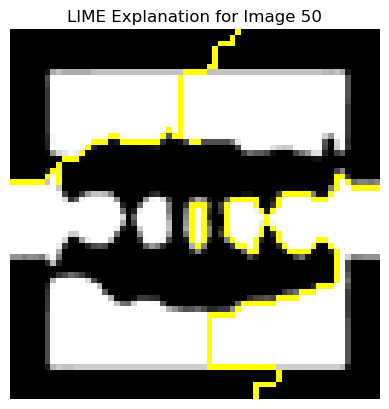

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


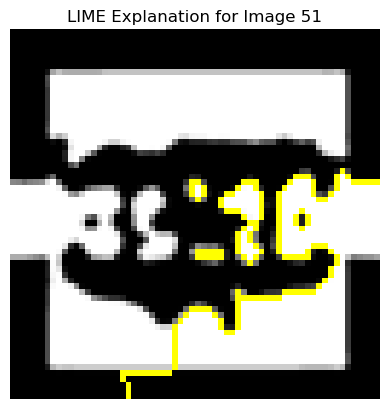

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


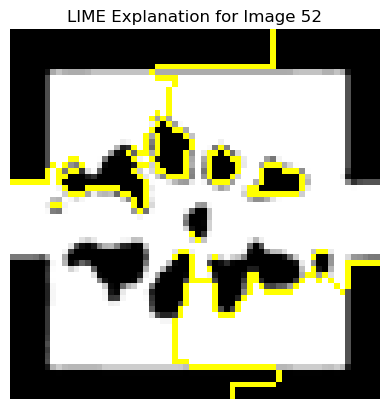

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


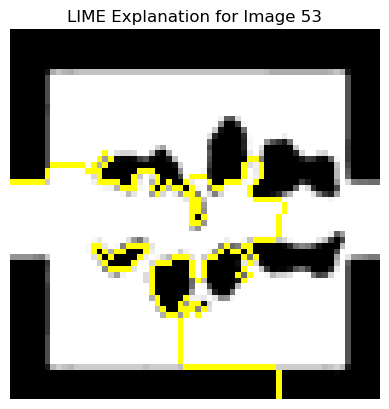

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


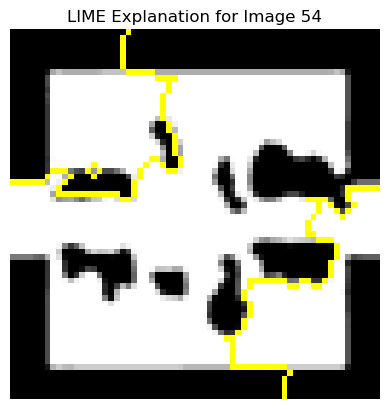

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


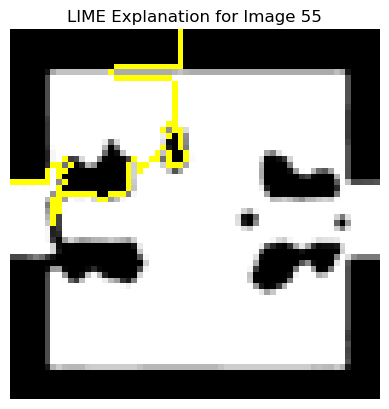

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


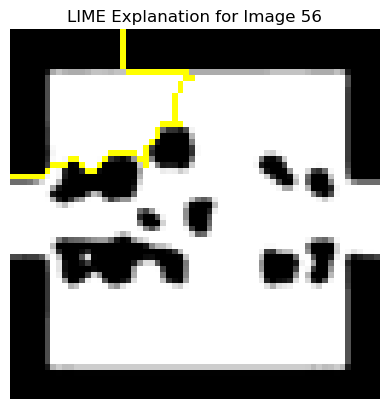

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


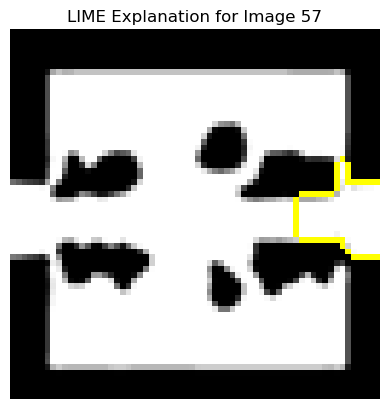

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 11ms/step


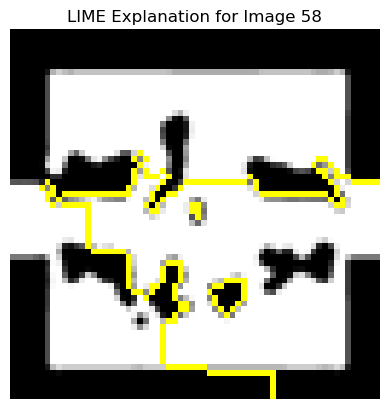

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 10ms/step


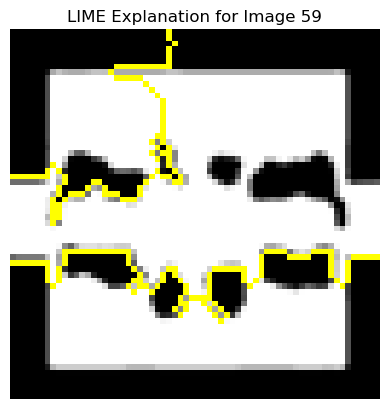

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 9ms/step


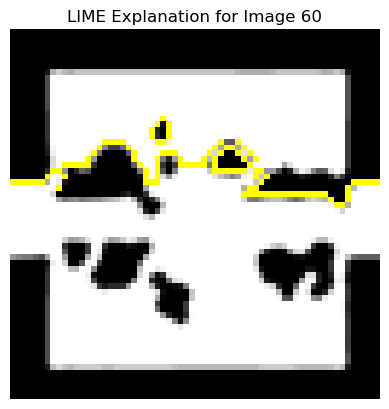

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Convert grayscale images to RGB for LIME
cropped_images_rgb = np.repeat(cropped_images, 3, axis=-1)

# Define the prediction function for LIME
def autoencoder_predict(images):
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert back to grayscale
    return encoder.predict(images_gray).reshape(images.shape[0], -1)

# Function to explain an instance using LIME
def explain_instance_with_lime(image, autoencoder_predict):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(image, autoencoder_predict, top_labels=1, hide_color=0, num_samples=1000)
    return explanation

# Function to plot LIME explanation
def plot_lime_explanation(explanation, image, index):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f'LIME Explanation for Image {index}')
    plt.axis('off')
    plt.show()

# Run the LIME explanation on all cropped images
for i, image_rgb in enumerate(cropped_images_rgb):
    explanation = explain_instance_with_lime(image_rgb, autoencoder_predict)
    plot_lime_explanation(explanation, image_rgb, i)
